In [1]:
import matplotlib.pyplot as plt
import matplotlib 
import matplotlib.image as mpimg
import numpy as np
from numpy.random import random
import cProfile

from tools import *
from visualization import *

%matplotlib inline
%reload_ext autoreload
%autoreload 2

# Modeling the Impact of Environmental Consciousness on the Supply-Demand Relationship between Firms and Customers

We present an agent-based model for studying the role of environmental consciousness on the supply-demand relationship between firms and customers.
In this model, we have two types of agents firms and customer.
All firms produce a similar product and all customer have a demand for this same product.
However, firms emit (e.g., CO2) differently in their production process and customers have hetereogenous sensitity to their emission.
Precisely, customers may decide to recieve less product from more emitting firm or even decide to not recieve products at all from these firms.
Firms may respond to this decrease in demand by decreasing their emission when they overproduce, i.e., when their product are not sold.
Also, customers may either search for new firms or decrease their sensitity when not recieving enough products 

More details about the model are in the paper [Modeling the Impact of Environmental Consciousness on the Supply-Demand Relationship between Firms and Customers](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4403242).

The notebook is divided in three main sections:

1. Network generation
2. Introducing demand and supply, enviromental consciuosness and customers' utility
3. Agents' strategies to decrease their shortages and overproduction


In the first setction, we present how the system is generated, i.e., how customers and firms and related, and how we model and visualize these relations.
In the second section, we dive into our model and introduce heterogenities to our agents to define their demand and production, and enviromental consciousness. Moreover, we model and analyze how this last feature affect the supply-demand balance in the sytem. 
In the last section, we simulate different scenarios of how agents may decrease their shortages and overproduction.

## Network generation
For our agent-based model, we take a network representation: agents are represented as nodes and their relations are represented as links. 

For initializing the system, we assume that the number of customers is much larger compared to the number of firms.
We also assume that firms supply a very large number of customers, while customers are supplied by a small number of firms.
To fullfill these assumptions, we need a degree sequence where very few nodes have many links, while the majority have a small number of links.
Such *heterogeneity* in the degree sequence may be produced by sampling from broad distributions, such as a [power-law, power-law with cut-off, log-normal, or stretched exponential](https://arxiv.org/abs/0706.1062).
Among these equivalent alternatives, we choose the $P\left(k\right) = k^{-\kappa_1} \cdot e^{-\kappa_2 \cdot k}$ ,i.e., [power-law with an exponential cut-off](https://en.wikipedia.org/wiki/Power_law#Power_law_with_exponential_cutoff).
This distribution is genereted using the function `broad_dist_degrees`. 

For visualization purposes, we choose the network to have 50 agents. Then, we divide the agents in two groups depending on their degree: 1) agents with degrees less than 10 are customers, and 2) agents with degrees more than 10 are firms.

At the beginning, all the links between firms and customers are positive, because they are useful to each other: firms sell products to customers and customers receive products from firms. We visualize this link in `black`. Links between firms are negative at the beginning, because they compete for customers; links between customers are also negative because they compete for products from firms. We visualize this link in `red`.

In [2]:
# generate a network with 50 agents and assign the attributes needed
g_small = {"firm_count":0}
while g_small["firm_count"]!=5:
    # we generate a broad-distributed sequence and use it to generate netork
    broad_dist = broad_dist_degrees(N_agents = 50, kappa1 = 2.1, kappa2 = 0.004)
    g_small = ig.Graph.Realize_Degree_Sequence(broad_dist, method= "smallest")
    # we assign the attributes needed to the network
    g_small = type_assignment(g_small)
    g_small = sign_assignment(g_small)
    g_small = c_f_links(g_small)
    g_small = network_conclusion(g_small)

In [3]:
# or import existing network
#g_small = ig.load("g_small_simple.graphml")

In [4]:
# we print the characteristics of the network
# In our model, we have 5 firms and 45 customers
# If the number of firms or custoemrs is not what we want, we can regenerate the network with the code above
print("Network with 'smallest' method:")
print("There are {0} firms and {1} customers.".format(g_small['firm_count'], g_small['customer_count'])) 
print("There are {0} positive links of firms and customers.".format(g_small['f_c_links']))
print("There are {0} negative links of firms and firms.".format(g_small['f_f_links']))
print("There are {0} negative links of customers and customers.".format(g_small['c_c_links']))
print("--------------------")

Network with 'smallest' method:
There are 5 firms and 45 customers.
There are 96 positive links of firms and customers.
There are 7 negative links of firms and firms.
There are 16 negative links of customers and customers.
--------------------


In [5]:
# we set visualization characteristics to the network
g_small = network_visualization(g_small, min_size = 6, max_size =80)
# create a layout for the network visualization as a circle
my_layout = g_small.layout("circular")
# we put the firms in the center of the network, and customers around them
firms_index = []               # the index of all the firms in the network
for i in range(len(g_small.vs)):
    if g_small.vs[i]["type"] == "firm":
        firms_index.append(i)

# we set the positions of the firms in the center if there are 5 firms
center_pos = [(-0.1,-0.1), 
              (0.35,0.35),
              (-0.35, -0.35),
              (-0.35,0.35),
              (0.35, -0.35)
             ]
if len(center_pos) >= len(firms_index):
    for k,i in enumerate(firms_index):
        my_layout[i] = center_pos[k]

# remind the user to change the center_pos if there are more than 5 firms
else:
    print("we have too many firms, change center_pos")

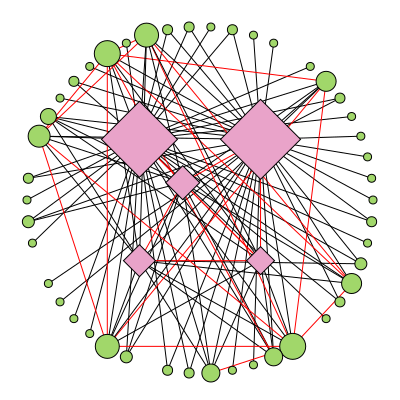

In [6]:
# visualize the network with the firms in the center, save the figure
visual_style = {}
out_name = "figures/simple_smallest_graph_n.png"
visual_style["bbox"] = (400,400)
visual_style["margin"] = 27
visual_style["layout"] = my_layout
ig.plot(g_small, out_name, **visual_style)

## Introducing demand and supply, enviromental consciuosness and customers' utility

We now dive into the core of our model.

As *first* step, we **only** study the `supply and demand balance` in the customer-firm network.  
In this network, all the links between firms and customers are positive. 
Firms evenly distribute their production to its customers, customers evenly ask their demand from their neighboring firms. 
Despite this even restribution agents (customers and firms) are `heterogeneous` in various aspects:

1) number of customer-firm links ($k_i$ for custoemrs and $k_K$ for firms), this heterogenity is created by the network strcuture

2) demand of customers $d_i$ is sampled from a normal distribution $d_i \sim \mathcal{N} (1,0.05)$, while the production of firms is given  by $p_K\sim\mathcal{N}(9,0.45)$. By this, we have that the expected total demand is 45 and the expcted total supply is also 45.

Before introducing environmental consciousness, firms evenly supply products to its customers and customers evenly ask their neighboring firms for products.
Even thogh, we set that the global demand matches the global supply, we will still have overproduction and shortages.
These occurs not only for stochastich fluctutations but mainly because of the network structure.


In a *second* step, we will introduce `enviromental consciuosness`. This is defined as "the level that an individual or an organization care about environmental issues". In other words, customers with high environmental consciousness prefer "green products" and firms with high environmental consciousness produce in a more "green" manner. 

We operationalize this using a one dimensional variable $\eta_i$ or $\eta_K$ for customers or firms, respectively. The initial enviromental consciuosness is sampled from a uniform distribution between 1 and 2. The final consciuosness will depend on the action agents take. 

In the *third* step, we define customers' `utility` and assign the `signs` of cutomer-firm relations according to the utility. A customer's utility with a neighboring firm is ($u_{iK}$) defined as:
$$
\textrm{$u_{iK}=\Theta[\epsilon_{i}-e_{K}]$}
$$
Where $e_{K}$ is the pollution (carbon emissions) firm $K$ expects to send customer $i$, and $\epsilon_{i}$ is customer $i$'s tolerance threshold of pollution from one of its neighboring firm. Customer $i$ will receive products from firm $K$ **only when** $u_{iK} = 1$. Otherwise their relation is negative ($u_{iK} = 0$) and no product will flow from firm $K$ to customer $i$.

Note that customers prefer to buy product from firms with higher $\eta_K$, this is capture in their choice function:
$$
\textrm{$d_{iK} =  u_{iK} \ d_i  \frac{e^{( - \eta_i \cdot f_{Ki})}}{\sum\nolimits_{J\in \left\Vert {k_{i}^{\mathrm{p}}}\right\Vert} e^{(-\eta_i \cdot f_{Ji})}}$}
$$
Where $f_{Ki}$ indicates the pollution firm $K$ expects to send customer $i$, $f_{Ji}$ indicates the pollution a random neiboring firm expects to send customer $i$. 

To understand the importance of the enviromental consciousness and the utlity of the agents (point 3), we first show the satisfaction of customers and firms in their abscencen. Then, we will introducde them.

In [7]:
signed_graph = g_small.copy()# copy the network from above

# Assign the useful "lists" of the network (their meaning see "tools.py")
# Everytime after copying the network, we need to assign the lists again
signed_graph = firm_list(signed_graph)
signed_graph = customer_list(signed_graph)
signed_graph = potential_firm(signed_graph)

In [8]:
# we set a constant demand (per customer), and calculate production (per firm)
# total production equals total demand
# the two constants will be the means of the normal distribution of demand and production respectively
demand_const = 1
production_const = demand_const * signed_graph["customer_count"] / signed_graph["firm_count"] 

In [9]:
# assign production and demand
signed_graph = production_demand_hetero(signed_graph, production_const, demand_const, p_dev = 0.45, d_dev =0.05) 
#assign environmental consciousness and compute pollution
signed_graph = env_assign(signed_graph, c_lower = 1, c_upper = 2, f_lower = 1, f_upper = 2) 
# calculate the local pollution of firms
signed_graph = local_pollution(signed_graph) 
#all the links are positive between firsm and customers. i.e., no environmental consciousness
signed_graph = sign_assignment(signed_graph) 
# calculate the shortage of customers and overproduction of firms
signed_graph = shortage_signed(signed_graph) 
# prepare the network for visualization
signed_graph = network_visualization(signed_graph, min_size = 6, max_size =80) 
# calculate the satisfaction levels of customers and firms
signed_graph = demandsatisfied_color(signed_graph, n_c=3, mid=0.85) 

To quantify the satisfactoin level of customers, we calculate the satisfaction levels of firms and customers:
1) the percentage of every customer's demand that is satisfied, 
2) the percentage of every firm's production that is sent to customers.
We color the agents depending on their satisfaction level: customers satisfing less than 85% of their demand are red, blue otherwhise. Firms sending less than 85% of their production are red, blue otherwhise.

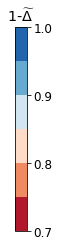

In [10]:
# colorbar to show the satisfaction levels of customers and firms
my_colormap = matplotlib.colors.LinearSegmentedColormap.from_list("my_colors",
                                                                  ["#b2182b", 
                                                                   "#ef8a62", 
                                                                   "#fddbc7", 
                                                                   "#d1e5f0", 
                                                                   "#67a9cf", 
                                                                   "#2166ac"],
                                                                 N=6)
# generate the colorbar for demand satisfied of individual customers
colorbar(cmap = my_colormap, 
         v_min = 0.70, v_max = 1.0, v_mid = 0.85, 
         show=True, 
         title = r"1-$\widetilde{\Delta}$",               #  delta is the percentage of demand shortage (customer) or production not sold (firm)
         filename = "figures/colorbar-diff-red_blue.png")

Using the above color scheme, we can now show the satisfaction level of the agents.

WITHOUT ENVIROMENTAL CONSCIOUSNESS

Agents suffering shortages and overproduction are shown in red
Agents in blue are satisfied about their states



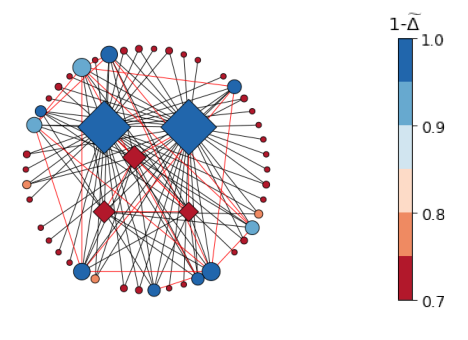

In [11]:
visual_style = {}
out_name = "figures/simple_hetero_graph_node_color_ds_and_ps_withOUT_eta.png"
visual_style["bbox"] = (400,400)
visual_style["margin"] = 27
visual_style["layout"] = my_layout
print("WITHOUT ENVIROMENTAL CONSCIOUSNESS\n")
print("Agents suffering shortages and overproduction are shown in red")
print("Agents in blue are satisfied about their states\n")
ig.plot(signed_graph, out_name, **visual_style)
plt.figure(figsize=(10,6))
columns = 2
net_vis = mpimg.imread(out_name)
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(net_vis)
satisfaction_level = mpimg.imread("figures/colorbar-diff-red_blue.png")
plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(satisfaction_level)
plt.subplots_adjust(wspace=0, hspace=0)

We see that several agents are colored in blue, which means their satisfaction level is above $85\%$.

We now change the sign of the links depending on the utlity function of the customers that depend on the enviromental consciousness. When a link becomes red between a customer and firm, then, firms cannot supply product to that customer. Moreover, customers will prefer to have products from mroe enviromental friendly firms.

In [12]:
# compute the signs of the links between firms and customers depending on the environmental consciousness
signed_graph = sign_assign_utility(signed_graph, alpha = 1, uthr = 0)
# calculate the satisfaction levels of customers and firms
signed_graph = shortage_signed(signed_graph)
signed_graph = network_visualization(signed_graph, min_size = 6, max_size =80)
signed_graph = demandsatisfied_color(signed_graph, n_c=3, mid=0.85)

WITH ENVIROMENTAL CONSCIOUSNESS

Agents suffering shortages and overproduction are shown in red
Agents in blue are satisfied about their states



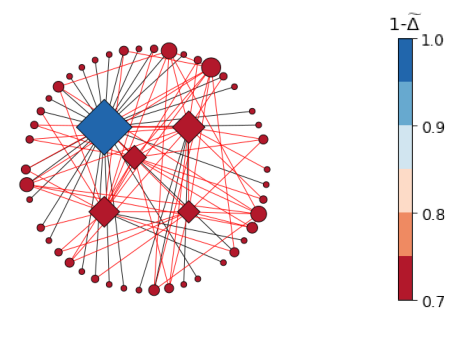

In [13]:
# visualize the network, showing the positive/negative links and agents' satisfaction levels
# this figure shows the positive/negative links and agents' satisfaction levels
visual_style = {}
starting_net = "figures/simple_hetero_graph_node_color_ds_and_ps_with_eta.png"
visual_style["bbox"] = (400,400)
visual_style["margin"] = 27
visual_style["layout"] = my_layout
print("WITH ENVIROMENTAL CONSCIOUSNESS\n")
print("Agents suffering shortages and overproduction are shown in red")
print("Agents in blue are satisfied about their states\n")
ig.plot(signed_graph, out_name, **visual_style)
plt.figure(figsize=(10,6))
net_vis = mpimg.imread(starting_net)
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(net_vis)
satisfaction_level = mpimg.imread("figures/colorbar-diff-red_blue.png")
plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(satisfaction_level)
plt.subplots_adjust(wspace=0, hspace=0)

We see that adding the enviromental consciousness increases the shortages and overproduction. 
Note that the only firm not overproducing is the larger one, i.e., the one with more customers.
However, this does not mean that this firm also has the highest enviromental consciuosness. 
Indeed, the reason that it is not overproducing is because it has many customers with positive relations.
This positive relations derives from the fact that the expected emission per customer ($e_{K}$) is low as the products are evenly distributed to all the customers.

How can firms and customers aovid this an increase their satisfaction level?

## Agents' strategies to decrease their shortages and overproduction

We focus on the customers' strategy when suffering from shortage: change $\eta_i$ (adaptation) or add new links with firms (rewiring).
In particular, we consider 3 different strategies of building new links:
 - [a] *Unilateral* link formation: the customer establishes a link to another firm *randomly*, and the firm has to accept this.
 - [b] *Bilateral* link formation: the firm will accept a new link from a customer only if it has a demand deficit. 
 - [c] *Smart* link formation: the customer establishes a link to another randomly chosen firm only if this warrants a positive utility, $u_{iK}=1$. The firm has to accept the link.  

In the agent-based model, the "*heterogeneity*" is reflected by different strategies choose by customers and firms.  

In the first step, firms or customers only **adjust their environmental consciousness** ($\eta$) to increase satisfaction level. No new links will be built in this step.

In the second step, firms and customers can choose different actions to increase satisfaction levels:
- Firms can choose to i) increase $\eta_K$ or ii) do not do anything.
- Customers can choose to i) decrease $\eta_i$ or ii) build a new supply-demand relation (link) with a non-neighboring firm.
In this step, we will show the simulations of two typical strategies [a] and [c].
By comparing the results of the *second* step with the *first* step (as well as by comparing the results of strategies [a] and [c]), we will see the impact of **changing network structure** on firms and customers' satisfaction levels. 

### Adjusting environmental consciousness only
In the following part, we will simulate the impact of *only* adjusting environmental consciousness on increaing satisfaction levels.
In the first simulation, only *customer* can take action: when they suffer from shortage, they will decrease their $\eta_i$ by $r_c$. Firms will not take any action in this simulation.
In the second simulation, only *firm* can take action: when they are over-producing, they will increase their $\eta_K$ by $r_f$. Customers will not take any action in this simulation.

We will plot at the end the distributions of environmental consciousness for firms and customers and see how they change.

No new links between customers and firms will be built in this part, which means the network structure will stay unchanged.

The simulation period is 5 time steps. For more details about this time, see the [paper](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4403242).

In [14]:
# Simulation 1: adjust the customers' environmental consciousness only
g_s = signed_graph.copy()
g_s = potential_firm(g_s)
# parameters are set as below, the simulation period is 5 time steps.
model_s = SignedNetwork(g_s, alpha = 1, uthr = 0, 
                               c_adapt = 1,       # c_adapt = 1 indicates customers adjust their environmental consciousness but not build new links
                               f_adapt = 1,
                               c_rate = 0.5,
                               f_rate = 0.0,      # f_rate = 0 indicates firms do not adjust their environmental consciousness
                               unilateral = True, bilateral = False, smart = False,
                               max_steps = 5)

model_s.run_model()

In [15]:
# collect the data of the simulation (only customers adjust)
df_c = model_s.datacollector.get_model_vars_dataframe()

ADJUSTING CUSTOMERS' ENVIRONMENTAL CONSCIOUSNESS ONLY

Agents suffering shortages and overproduction are shown in red
Agents in blue are satisfied about their states



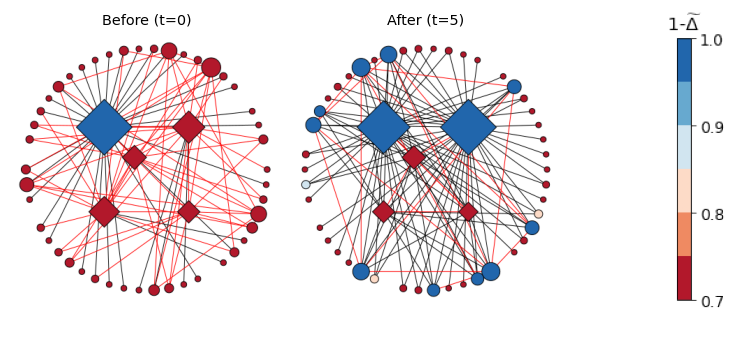

In [16]:
# visualize the network after simulation
g_s = network_visualization(g_s)
g_s = demandsatisfied_color(g_s, mid=0.85)

out_name = "figures/uni_changing_etai.png"
visual_style["bbox"] = (400,400)
visual_style["margin"] = 27
visual_style["layout"] = my_layout
print("ADJUSTING CUSTOMERS' ENVIRONMENTAL CONSCIOUSNESS ONLY\n")
print("Agents suffering shortages and overproduction are shown in red")
print("Agents in blue are satisfied about their states\n")
ig.plot(g_s, out_name, **visual_style)
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3,figsize=(15, 6)) 
ax1.title.set_text('Before (t=0)')
ax2.title.set_text('After (t=5)')
net_vis = mpimg.imread(starting_net)
ax1.axis('off')
ax1.imshow(net_vis)
net_vis = mpimg.imread(out_name)
ax2.axis('off')
ax2.imshow(net_vis)
satisfaction_level = mpimg.imread("figures/colorbar-diff-red_blue.png")
ax3.axis('off')
ax3.imshow(satisfaction_level)
plt.subplots_adjust(wspace=0, hspace=0)

In [17]:
# Simulation 2: adjust the firms' environmental consciousness only
g_s = signed_graph.copy()
g_s = potential_firm(g_s)
# run model in unilateral case
# parameters are set as below, the simulation period is 5 time steps.
model_s = SignedNetwork(g_s, alpha = 1, uthr = 0, 
                               c_adapt = 1, 
                               f_adapt = 1,
                               c_rate = 0.0,
                               f_rate = 0.5, 
                               unilateral = True, bilateral = False, smart = False,
                               max_steps = 5)

model_s.run_model()

In [18]:
# collect the data of the simulation (only firms adjust)
df_f = model_s.datacollector.get_model_vars_dataframe()

ADJUSTING FIRMS' ENVIRONMENTAL CONSCIOUSNESS ONLY

Agents suffering shortages and overproduction are shown in red
Agents in blue are satisfied about their states



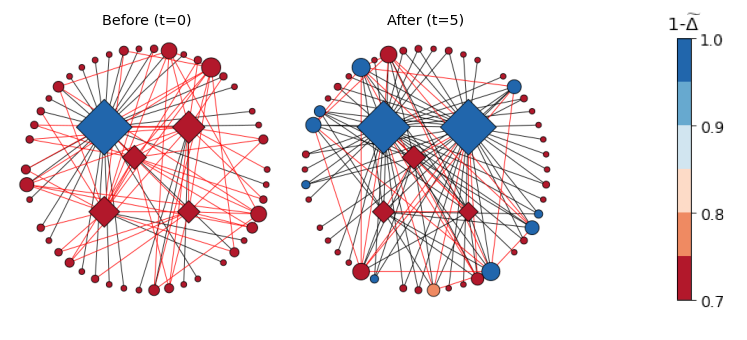

In [19]:
# visualize the network after simulation
g_s = network_visualization(g_s)
g_s = demandsatisfied_color(g_s, mid=0.85)

out_name = "figures/uni_changing_etak.png"
visual_style["bbox"] = (400,400)
visual_style["margin"] = 27
visual_style["layout"] = my_layout
print("ADJUSTING FIRMS' ENVIRONMENTAL CONSCIOUSNESS ONLY\n")
print("Agents suffering shortages and overproduction are shown in red")
print("Agents in blue are satisfied about their states\n")
ig.plot(g_s, out_name, **visual_style)
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3,figsize=(15, 6)) 
ax1.title.set_text('Before (t=0)')
ax2.title.set_text('After (t=5)')
net_vis = mpimg.imread(starting_net)
ax1.axis('off')
ax1.imshow(net_vis)
net_vis = mpimg.imread(out_name)
ax2.axis('off')
ax2.imshow(net_vis)
satisfaction_level = mpimg.imread("figures/colorbar-diff-red_blue.png")
ax3.axis('off')
ax3.imshow(satisfaction_level)
plt.subplots_adjust(wspace=0, hspace=0)

From both final networks, we find that after adjusting $\eta$, the number of negative (red) links decrease a lot and some agents become satisfied (in blue). However, still many customers suffer from shortages (in red) and most of the firms are still over-producing (in red). This indicates the current network structure resists agents to become further satisfied. 

As final plot, we show the distribution of environmantal consciousness to actually show that these has changed during the different simulations.

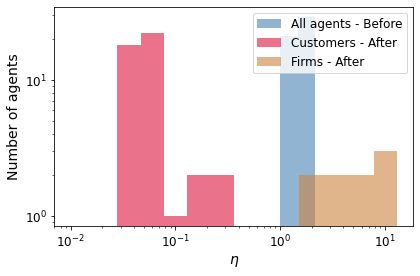

In [20]:
# visualize the changes of environmantal consciousness in the two simulations
c_b = df_c["Customer eta"][1]
c_a = df_c["Customer eta"][6]
f_b = df_f["Firm eta"][1]
f_a = df_f["Firm eta"][6]
fc_b = c_b + f_b

plt.clf()
#plt.xlim([0.001,100])
plt.yscale("log")
plt.xscale("log")
plt.hist(fc_b, alpha=0.6, bins=np.logspace(0,0.5, 4), 
         label = "All agents - Before", color="steelblue")
plt.hist(c_a,  alpha=0.6, bins=np.logspace(-2,0, 10), 
         label = "Customers - After",color="crimson")
plt.hist(f_a,  alpha=0.6, bins=[1.02, 1.5, 7.9, 13.0], 
         label = "Firms - After",color="peru")

plt.xlabel("$η$", fontsize =14)
plt.ylabel("Number of agents", fontsize = 14)
plt.legend(fontsize = 12)
plt.tight_layout()
plt.savefig("figures/eta_change.pdf", dpi = 300)
plt.show()

From the figure above, we see that everything works as epxected, i.e., customers decrease their environmantal consciousness, while firms increase it. However, there is one execption, the larger firm that had many customers was never overproducing so it never changed its environmantal consciousness.

### With *unilateral* link formation strategy (strategy [a])
In the following part, customers can increase satisfaction levels by not only adjusting $\eta_i$ but also building new links with non-neighboring firms. The link formation strategy is "unilateral", which means firms will accept new customers without any condition. Unilateral strategy is the most "open" link formation strategy among the three, under which is expected to build the most new customer-firm links.

In this part, if suffering from shortage, a customer can choose to decrease $\eta_i$ by $r_c$ with a probability $p_c$. Also, the customer can also choose to build a new link with a non-neighboring firm with a probability $p_c$.

Also, for over-producing firms, they have a probability $p_f$ to increase $\eta_K$ bt $r_f$, and also with $1 - p_f$ to do nothing.

The simulation period is 5 time steps. If in every time step every customer chooses building new links, then after 5 time steps the 45 customers will be fully connected with the 5 firms, regardless of the initial structure of the network.

To well visualize the network structure changes as well as the changes of agents' satisfaction levels, we select two time points within the 5 time steps. The first is after 2 time steps, when just a few links between customers and firms are built. The second is after 4 time steps, when many new links between firms and customers have been built.

In [21]:
# Simulate with unilateral strategy, with p_c =0.2, t = 2
# In this case, when a customer is not satisfied, it has 20% probability to adjust its environmental consciousness, and 80% probability to build a new link
g_s = signed_graph.copy()
g_s = potential_firm(g_s)
# the meanings of parameters can be found in "model.py"
# we want to visualize the network after 2 time steps first, in order to compare the network after 4 steps afterwards
model_s = SignedNetwork(g_s, alpha = 1, uthr = 0, 
                               c_adapt = 0.2, 
                               f_adapt = 1.,
                               c_rate = 0.65,
                               f_rate = 0.0, 
                               unilateral = True, bilateral = False, smart = False,
                               max_steps = 2)

model_s.run_model()

WITH STRATEGY 'UNILATERAL', p_c = 0.2, t = 2

Agents suffering shortages and overproduction are shown in red
Agents in blue are satisfied about their states



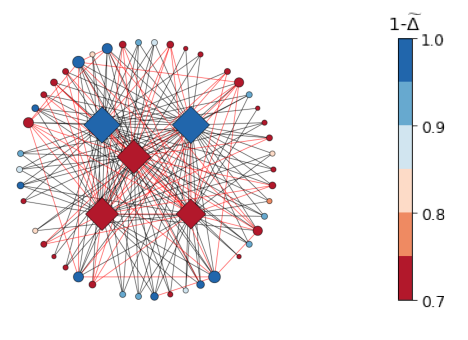

In [22]:
# Visualize the network after 2 time steps with uni-rule
g_s = network_visualization(g_s)
g_s = demandsatisfied_color(g_s, mid=0.85)

out_name = "figures/uni_t2_pc02.png"

visual_style["bbox"] = (600,600)
visual_style["margin"] = 27
visual_style["layout"] = my_layout
print("WITH STRATEGY 'UNILATERAL', p_c = 0.2, t = 2\n")
print("Agents suffering shortages and overproduction are shown in red")
print("Agents in blue are satisfied about their states\n")
ig.plot(g_s, out_name, **visual_style)
plt.figure(figsize=(10,6))
net_vis = mpimg.imread(out_name)
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(net_vis)
satisfaction_level = mpimg.imread("figures/colorbar-diff-red_blue.png")
plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(satisfaction_level)
plt.subplots_adjust(wspace=0, hspace=0)

In [23]:
# Simulate with unilateral strategy, with p_c =0.2, t = 4
# In this case, when a customer is not satisfied, it has 20% probability to adjust its environmental consciousness, and 80% probability to build a new link
g_s = signed_graph.copy()
g_s = potential_firm(g_s)
# run model in unilateral case
# we want to visualize the network after 4 time steps, in order to compare the network after 2 steps before
# All the parameters are the same as above
model_s = SignedNetwork(g_s, alpha = 1, uthr = 0, 
                               c_adapt = 0.2, 
                               f_adapt = 1.,
                               c_rate = 0.65,
                               f_rate = 0.0, 
                               unilateral = True, bilateral = False, smart = False,
                               max_steps = 4)

model_s.run_model()

WITH STRATEGY 'UNILATERAL', p_c = 0.2, t = 4

Agents suffering shortages and overproduction are shown in red
Agents in blue are satisfied about their states



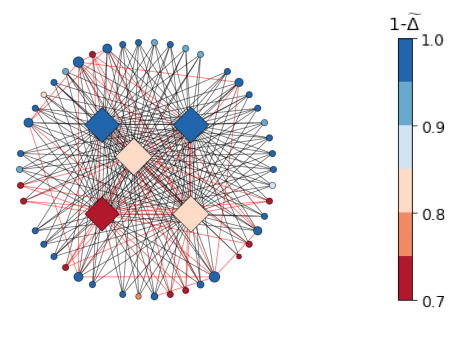

In [24]:
# Visualize the network after 4 time steps with uni-rule
g_s = network_visualization(g_s)
g_s = demandsatisfied_color(g_s, mid=0.85)

out_name = "figures/uni_t4_pc02.png"
visual_style["bbox"] = (600,600)
visual_style["margin"] = 27
visual_style["layout"] = my_layout
print("WITH STRATEGY 'UNILATERAL', p_c = 0.2, t = 4\n")
print("Agents suffering shortages and overproduction are shown in red")
print("Agents in blue are satisfied about their states\n")
ig.plot(g_s, out_name, **visual_style)
plt.figure(figsize=(10,6))
net_vis = mpimg.imread(out_name)
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(net_vis)
satisfaction_level = mpimg.imread("figures/colorbar-diff-red_blue.png")
plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(satisfaction_level)
plt.subplots_adjust(wspace=0, hspace=0)

Comparing the two networks above, we find that at t = 4 most of the agents are satisfied. Especially, there are less negative links (in red) between firms and customers at t = 4 than t = 2. This indicates builidng more customer-firm links can make it easier for customers to gain positive utility from neighboring firms and make more agents satisfied.

#### Changing $p_c$
In the following part, we simulate with $p_c = 0.85$, which means when a customer suffers from shortages, it has $85\%$ probability to decrease $\eta_i$ but just $15\%$ probability to build a link with a new firm.
We simulate the model with t = 2 and t = 4 (and other parameters the same), in order to compare the results with the case $p_c = 0.2$ (when customers are more likely to build new links when they suffer from shortages).

In [25]:
# Simulate with unilateral strategy, with p_c =0.85, t = 2
# In this case, when a customer is not satisfied, it has 85% probability to adjust its environmental consciousness, and 15% probability to build a new link
g_s = signed_graph.copy()
g_s = potential_firm(g_s)
model_s = SignedNetwork(g_s, alpha = 1, uthr = 0, 
                               c_adapt = 0.85, 
                               f_adapt = 1.,
                               c_rate = 0.65,
                               f_rate = 0.0, 
                               unilateral = True, bilateral = False, smart = False,
                               max_steps = 2)

model_s.run_model()

WITH STRATEGY 'UNILATERAL', p_c = 0.85, t = 2

Agents suffering shortages and overproduction are shown in red
Agents in blue are satisfied about their states



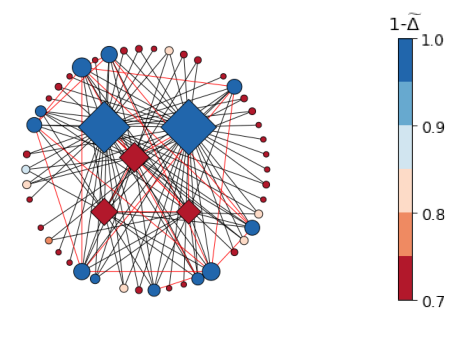

In [26]:
# Visualize the network after 2 time steps with uni-rule, p_c = 0.85
g_s = network_visualization(g_s)
g_s = demandsatisfied_color(g_s, mid=0.85)

out_name = "figures/uni_t2_pc85.png"
visual_style["bbox"] = (400,400)
visual_style["margin"] = 27
visual_style["layout"] = my_layout
print("WITH STRATEGY 'UNILATERAL', p_c = 0.85, t = 2\n")
print("Agents suffering shortages and overproduction are shown in red")
print("Agents in blue are satisfied about their states\n")
ig.plot(g_s, out_name, **visual_style)
plt.figure(figsize=(10,6))
columns = 2
net_vis = mpimg.imread(out_name)
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(net_vis)
satisfaction_level = mpimg.imread("figures/colorbar-diff-red_blue.png")
plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(satisfaction_level)
plt.subplots_adjust(wspace=0, hspace=0)

In [27]:
# Simulate with unilateral strategy, with p_c =0.85, t = 4
# In this case, when a customer is not satisfied, it has 85% probability to adjust its environmental consciousness, and 15% probability to build a new link
g_s = signed_graph.copy()
g_s = potential_firm(g_s)
model_s = SignedNetwork(g_s, alpha = 1, uthr = 0, 
                               c_adapt = 0.85, 
                               f_adapt = 1.,
                               c_rate = 0.65,
                               f_rate = 0.0, 
                               unilateral = True, bilateral = False, smart = False,
                               max_steps = 4)

model_s.run_model()

WITH STRATEGY 'UNILATERAL', p_c = 0.85, t = 4

Agents suffering shortages and overproduction are shown in red
Agents in blue are satisfied about their states



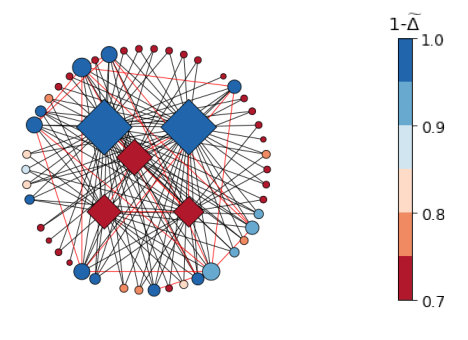

In [28]:
# Visualize the network after 4 time steps with uni-rule, c_adapt = 0.85
g_s = network_visualization(g_s)
g_s = demandsatisfied_color(g_s, mid=0.85)

out_name = "figures/uni_t4_pc85.png"
visual_style["bbox"] = (400,400)
visual_style["margin"] = 27
visual_style["layout"] = my_layout
print("WITH STRATEGY 'UNILATERAL', p_c = 0.85, t = 4\n")
print("Agents suffering shortages and overproduction are shown in red")
print("Agents in blue are satisfied about their states\n")
ig.plot(g_s, out_name, **visual_style)
plt.figure(figsize=(10,6))
columns = 2
net_vis = mpimg.imread(out_name)
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(net_vis)
satisfaction_level = mpimg.imread("figures/colorbar-diff-red_blue.png")
plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(satisfaction_level)
plt.subplots_adjust(wspace=0, hspace=0)

By comparing the networks respectively, we find that, at t = 2, more agents are satisfied when $p_c = 0.85$ then when $p_c = 0.2$. The reason is with $p_c = 0.2$, most of the new links between firms and cusotmers and firms are negative and no products can flow through these links. When t = 4, with more links built and most of them become positive, firms can well sell products and customers can better satisfy demand ($p_c = 0.2$). This indicates that although some new links cannot be used immediately, they can help increase agents's satisfaction levels later. 

### Analyzing the optimal parameters 
From the analysis above we can find thet for parameters determine the final satisfaction levels of the agents. They are:
 1) The probability that a customer chooses to decrease environmental consciousness ($p_c$)
 2) The rate that a customer will adjust its environmental consciousness in one time step ($r_c$) 
 3) The probability that a firm chooses to increase environmental consciousness ($p_f$)
 4) The rate that a firm will adjust its environmental consciousness in one time step ($r_f$)
 
In the next part we will figure out what combination of these four parameters will lead to the optimal condition (i.e., the average satisfaction level of agents is the highest).
We use the criteria **total relative demand covered for all customers** to evaluate the level of satisfaction. It is calculated as the total the sum of the products that all the customers receive by the sum of the demand of all the customers.
Since there is a global supply-demand balance, the average satisfaction of firms is the same as customers.

Because it is not easy to show the combination of the four parameters in a four-dimensional space, we do the simulations and visualizations in two steps:

In the *first* step, we find customers' parameters. In this case, firms will act with optimal parameters (i.e., $p_f = r_f ~ 1$). We make combination of $p_c$ and $r_c$ values and simulate their impacts on agents' average satisfaction level.

In the *second* step, owe find firms' parameters. In this case, customers will act with optimal parameters (i.e., $p_c = 0$). We make combination of $p_f$ and $r_f$ values and simulate their impacts on agents' average satisfaction level.

We show the visualization with **unilateral** and **smart** strategy. With *unilateral* strategy the most new links between firms and customers and will be built among the three strategies and with *smart* rule the least new links will be built (i.e., **bilateral** lies in the middle and the characteristics are relatively not that representative).  

In [29]:
# before the simulation, we need to assign the lists again
g_s = signed_graph.copy()
g_s = potential_firm(g_s)
n=11 # number of points in the interval [0,1] that will be explored for each paramter of the model

In [30]:
# This can take quite a while.
# Already with one sample, you should see the patterns reported in the paper.
# With more samples, fluctutations may be removed.
gu_all, dsu_all, gb_all, dsb_all, gs_all, dss_all = create_heatmap(g_s, n_cores=16, n=11, sample=10)

In [31]:
# # Store the simulations results
# import pickle
# with open("data/out_put/dsu.pk", "wb") as f:
#     pickle.dump(dsu_all, f)
# with open("data/out_put/dsb.pk", "wb") as f:
#     pickle.dump(dsb_all, f)
# with open("data/out_put/dss.pk", "wb") as f:
#     pickle.dump(dss_all, f)
# with open("data/out_put/gu.pk", "wb") as f:
#     pickle.dump(gu_all, f)
# with open("data/out_put/gb.pk", "wb") as f:
#     pickle.dump(gb_all, f)
# with open("data/out_put/gs.pk", "wb") as f:
#     pickle.dump(gs_all, f)

In [32]:
## Import the simulations results
# import pickle
# with open("data/out_put/dsu.pk", "rb") as f:
#     dsu_all = pickle.load(f)
# with open("data/out_put/dsb.pk", "rb") as f:
#     dsb_all = pickle.load(f)
# with open("data/out_put/dss.pk", "rb") as f:
#     dss_all = pickle.load(f)
# with open("data/out_put/gu.pk", "rb") as f:
#     gu_all = pickle.load(f)
# with open("data/out_put/gb.pk", "rb") as f:
#     gb_all = pickle.load(f)
# with open("data/out_put/gs.pk", "rb") as f:
#     gs_all = pickle.load(f)

We evaluate the simulations with **unilateral** link fromation, i.e. rule [a].
First, we find the optimal parameters and then visualize the results in two heat maps. 
In one heatmap, we fix firms paramters to their optimal values and visualize how the defict changes when changing the customers' parameters. On the second heatmap, we d the opposite, i.e., we fix customers paramters to their optimal values and visualize how the defict changes when changing the firms' parameters

In [33]:
dims = dsu_all.shape
flattened_index = np.argmax(dsu_all)
f_a_opt_index_u, f_r_opt_index_u, c_r_opt_index_u,c_a_opt_index_u = np.unravel_index(flattened_index, shape=dims)
f_a_opt = np.linspace(0,1,n)[f_a_opt_index_u]
f_a_opt = np.round(f_a_opt,1)
f_r_opt = np.linspace(0,1,n)[f_r_opt_index_u]
f_r_opt = np.round(f_r_opt,1)
c_a_opt = np.linspace(0,1, n)[c_a_opt_index_u]
c_a_opt = np.round(c_a_opt,1)
c_r_opt = np.linspace(0,1, n)[c_r_opt_index_u]
c_r_opt = np.round(c_r_opt,1)

In [34]:
# plot the heat map of the demand satisfied with different values of parameters
v_min = 0.7
v_max = 1.0
v_mid = 0.85

heat_map_ds(matrix = dsu_all[f_a_opt_index_u,f_r_opt_index_u,:,:], 
             filename = "figures/ds-uni-cr-vs-ca.pdf", 
             show=False,
             xticks = True, 
             xlabel= "$p_{c}$", 
             ylabel= "$r_{c}$",
             v_min = v_min, v_max = v_max, v_mid = v_mid,
             my_colormap = my_colormap)
# #
heat_map_ds(matrix = dsu_all[:,:,c_r_opt_index_u,c_a_opt_index_u], 
             filename = "figures/ds-uni-fr-vs-fa.pdf", 
             show=False,
             xticks = True, 
             xlabel= "$p_{f}$", 
             ylabel= "$r_{f}$",
             v_min = v_min, v_max = v_max, v_mid = v_mid,
             my_colormap = my_colormap)

<Figure size 255.118x255.118 with 0 Axes>

<Figure size 354.331x354.331 with 0 Axes>

In [35]:
# generate the colorbar for the demand satisfied of on the network level
colorbar(cmap = my_colormap, 
         v_min = 0.70, v_max = 1.0, v_mid = 0.85, 
         show=False, 
         title = r"$\mathcal{C}$",
         filename = "figures/colorbar-diff-red_blue-total-rel-demand-met.pdf")

<Figure size 78.7402x354.331 with 0 Axes>

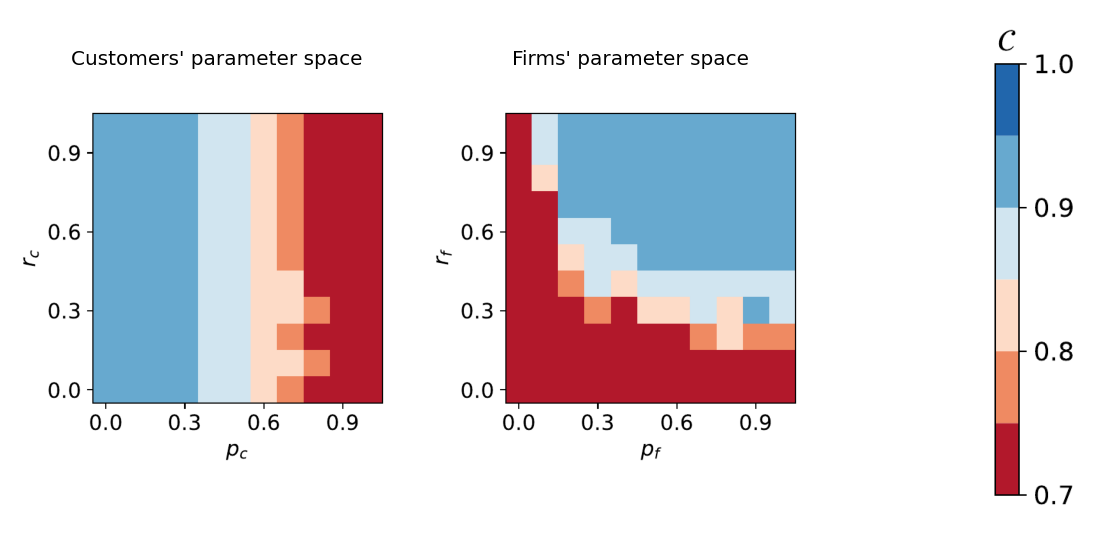

In [36]:
from pdf2image import convert_from_path
pdf_path1 = "figures/ds-uni-cr-vs-ca.pdf"
pdf_path2 = "figures/ds-uni-fr-vs-fa.pdf"
pdf_path3 = "figures/colorbar-diff-red_blue-total-rel-demand-met.pdf"
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3,figsize=(16, 7)) 
ax1.title.set_text("Customers' parameter space")
ax2.title.set_text("Firms' parameter space")
ax1.axis('off')
image1 = convert_from_path(pdf_path1)[0]
ax1.imshow(image1)
ax2.axis('off')
image2 = convert_from_path(pdf_path2)[0]
ax2.imshow(image2)
ax3.axis('off')
image3 = convert_from_path(pdf_path3)[0]
ax3.imshow(image3)
plt.subplots_adjust(wspace=0, hspace=0)

From the two heat maps above, we find that:
1) For customers' parameters, the optimized solution appears on the left column ($p_c \sim 0$), which means customers do not decrease their environmental consciousness but try their best to build more links with firms.
2) For firms' parameters, the optimized solution appears on the upper-right corner ($p_f \sim 1$ and $r_f \sim 1$). This indicates firms should try their best to increase environmental consciousness.

We create the same heatmap above, but for the system following rule [c],namely the apparently *smarter* rule.

In [37]:
dims = dss_all.shape
flattened_index = np.argmax(dss_all)
f_a_opt_index_s, f_r_opt_index_s, c_r_opt_index_s,c_a_opt_index_s = np.unravel_index(flattened_index, shape=dims)
f_a_opt = np.linspace(0,1,n)[f_a_opt_index_s]
f_a_opt = np.round(f_a_opt,1)
f_r_opt = np.linspace(0,1,n)[f_r_opt_index_s]
f_r_opt = np.round(f_r_opt,1)
c_a_opt = np.linspace(0,1, n)[c_a_opt_index_s]
c_a_opt = np.round(c_a_opt,1)
c_r_opt = np.linspace(0,1, n)[c_r_opt_index_s]
c_r_opt = np.round(c_r_opt,1)

In [38]:
# plot the heat map of the demand satisfied with different values of parameters
v_min = 0.7
v_max = 1.0
v_mid = 0.85

heat_map_ds(matrix = dss_all[f_a_opt_index_s,f_r_opt_index_s,:,:], 
             filename = "figures/ds-smart-cr-vs-ca.pdf", 
             show=False,
             xticks = True, 
             xlabel= "$p_{c}$", 
             ylabel= "$r_{c}$",
             v_min = v_min, v_max = v_max, v_mid = v_mid,
             my_colormap = my_colormap)
# #
heat_map_ds(matrix = dss_all[:,:,c_r_opt_index_s,c_a_opt_index_s], 
             filename = "figures/ds-smart-fr-vs-fa.pdf", 
             show=False,
             xticks = True, 
             xlabel= "$p_{f}$", 
             ylabel= "$r_{f}$",
             v_min = v_min, v_max = v_max, v_mid = v_mid,
             my_colormap = my_colormap)

<Figure size 354.331x354.331 with 0 Axes>

<Figure size 354.331x354.331 with 0 Axes>

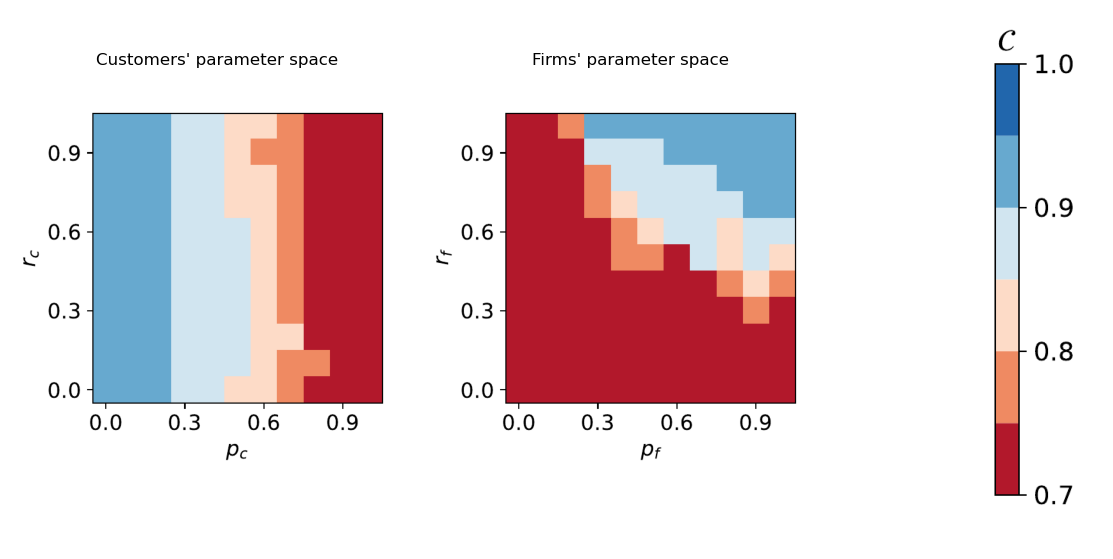

In [39]:
pdf_path1 = "figures/ds-smart-cr-vs-ca.pdf"
pdf_path2 = "figures/ds-smart-fr-vs-fa.pdf"
pdf_path3 = "figures/colorbar-diff-red_blue-total-rel-demand-met.pdf"
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3,figsize=(16, 7)) 
ax1.title.set_text("Customers' parameter space")
ax2.title.set_text("Firms' parameter space")
ax1.axis('off')
image1 = convert_from_path(pdf_path1)[0]
ax1.imshow(image1)
ax2.axis('off')
image2 = convert_from_path(pdf_path2)[0]
ax2.imshow(image2)
ax3.axis('off')
image3 = convert_from_path(pdf_path3)[0]
ax3.imshow(image3)
plt.subplots_adjust(wspace=0, hspace=0)

From the two heat maps above, we find that the optimal solution appears with similar combination of parameters as with unilateral strategy (i.e., customers should try best to build more new links and firms should try best to increase environmental consciousness).

### Analyzing the difference between unilateral and smart strategy
First, we visualize the network when the **average satisfaction level** differs the most between *unilateral* and *smart* strategies. From the heat maps above, we find that the most distinctive differences appears with "intermediate" values of the firms' parameters (i.e., values of $p_f$ and $r_f$ are near the middle point of 0 and 0.9). The heat maps with smart rule are not shown

We choose $r_f = p_f = 0.4$, $p_c = 0$ and $r_c =0.4$ and visualize the network structure with unilateral and smart strategies respectively (note: when $p_c = 0$, it does not matter what value is $r_c$, because customers will not adjust environmental consciousness).

Second, we analyze the differences in **Gini coefficient**. Gini coefficient is widely used to measure inequality (such as inequality in income) in economics. Here we use Gini coefficient to represent the inequality of the products customers receive. We will calculate the difference of Gini coefficient with te two strategies under different combinations of the four parameters (i.e., p_c, p_f, r_c, r_f) and visualize them in heat maps.

In [40]:
# Simulate with "intermediate" values of the firms' parameters, and with unilateral strategy
# at the same time, customers act with optimal parameters (p_c = 0)
g_s = signed_graph.copy()
g_s = potential_firm(g_s)
# run model in unilateral case
model_s = SignedNetwork(g_s, alpha = 1, uthr = 0, 
                               c_adapt = 0,          #p_c
                               f_adapt = 0.4,        #p_f
                               c_rate = 0.4,         #r_c
                               f_rate = 0.4,         #r_f
                               unilateral = True, bilateral = False, smart = False,
                               max_steps = 5)

model_s.run_model()

WITH STRATEGY 'UNILATERAL', t = 5

p_f = 0.4, p_c = 0, r_f = 0.4, r_c = 0.4
Agents suffering shortages and overproduction are shown in red
Agents in blue are satisfied about their states



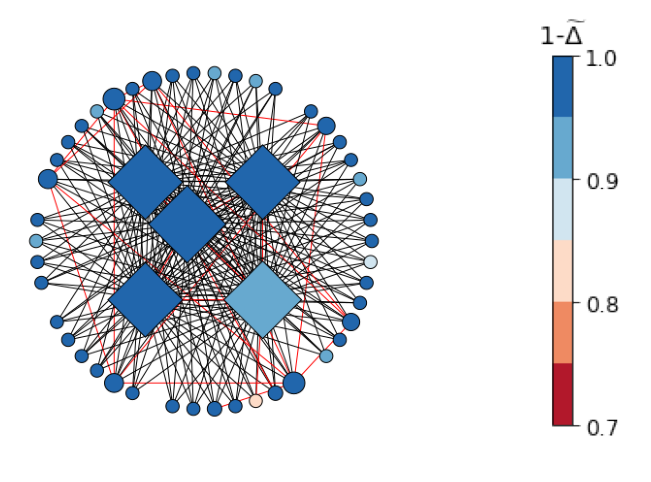

In [41]:
# visualize the network after 5 time steps with unilateral strategy, p_f = 0.4, p_c = 0, r_f = 0.4, r_c = 0.4
g_s = network_visualization(g_s)
g_s = demandsatisfied_color(g_s, mid=0.85)
out_name = "figures/uni_middle.png"
visual_style["bbox"] = (400,400)
visual_style["margin"] = 27
visual_style["layout"] = my_layout
print("WITH STRATEGY 'UNILATERAL', t = 5\n")
print("p_f = 0.4, p_c = 0, r_f = 0.4, r_c = 0.4")
print("Agents suffering shortages and overproduction are shown in red")
print("Agents in blue are satisfied about their states\n")
ig.plot(g_s, out_name, **visual_style)
plt.figure(figsize=(10,6))
columns = 2
net_vis = mpimg.imread(out_name)
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(net_vis)
satisfaction_level = mpimg.imread("figures/colorbar-diff-red_blue.png")
plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(satisfaction_level)
plt.subplots_adjust(wspace=0, hspace=0)

In [42]:
# Simulate with "intermediate" values of the firms' parameters, and with smart strategy
# at the same time, customers act with optimal parameters (p_c = 0)
g_s = signed_graph.copy()
g_s = potential_firm(g_s)
# run model in unilateral case
model_s = SignedNetwork(g_s, alpha = 1, uthr = 0, 
                               c_adapt = 0,      #p_c
                               f_adapt = 0.4,    #p_f
                               c_rate = 0.4,     #r_c
                               f_rate = 0.4,     #r_f
                               unilateral = False, bilateral = False, smart = True,
                               max_steps = 5)

model_s.run_model()

WITH STRATEGY 'SMART', t = 5

p_f = 0.4, p_c = 0, r_f = 0.4, r_c = 0.4
Agents suffering shortages and overproduction are shown in red
Agents in blue are satisfied about their states



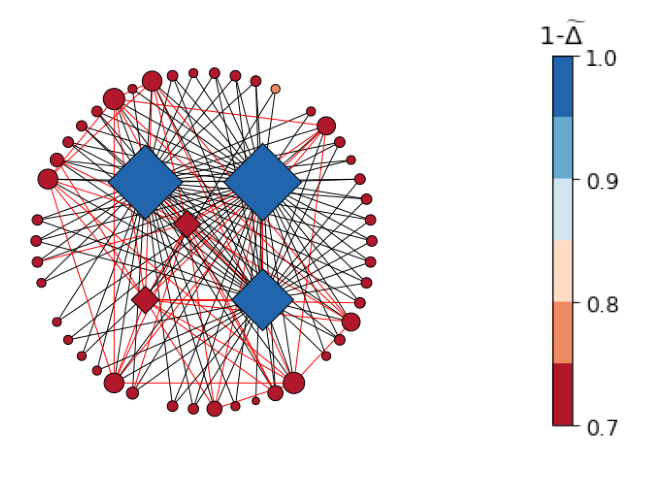

In [43]:
# visualize the network after 5 time steps with the parameter values above
g_s = network_visualization(g_s)
g_s = demandsatisfied_color(g_s, mid=0.85)

out_name = "figures/smart_middle.png"
visual_style["bbox"] = (400,400)
visual_style["margin"] = 27
visual_style["layout"] = my_layout
print("WITH STRATEGY 'SMART', t = 5\n")
print("p_f = 0.4, p_c = 0, r_f = 0.4, r_c = 0.4")
print("Agents suffering shortages and overproduction are shown in red")
print("Agents in blue are satisfied about their states\n")
ig.plot(g_s, out_name, **visual_style)
plt.figure(figsize=(10,6))
columns = 2
net_vis = mpimg.imread(out_name)
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(net_vis)
satisfaction_level = mpimg.imread("figures/colorbar-diff-red_blue.png")
plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(satisfaction_level)
plt.subplots_adjust(wspace=0, hspace=0)

From the two network graphs with firms' "intermediate" parameters, we find that with unilateral strategy there are more links built and most of these links are positive. Then products flow fluently from firms to customers and the average satisfaction level is high. 

Onthe contrary, with smart strategy, less new links are built and many links between firms and customers are negative. As a result, the average satisfaction level is lower than with unilateral strategy.

In the following part, we will visualize the difference of Gini coefficient.
Still, when test customers' parameters, firms will behave with optimal parameters (i.e., $p_f = r_f ~1$); when test firms' parameters, customers will behave with optimal parameters ($p_c = 0$).

In [44]:
# plot the heat map of the Gini coefficient with different values of parameters
# the heat maps show the differences in Gini coefficient between the smart and unilateral cases
v_min = -0.05
v_max = +0.05
v_mid = 0.0
heat_map_ds(matrix = gs_all[f_a_opt_index_s,f_r_opt_index_s,:-1,:-1]-gu_all[f_a_opt_index_u,f_r_opt_index_u,:-1,:-1], 
             filename = "figures/gini-diff-opt-firms.pdf", 
             show=False,
             xticks = True, 
             xlabel= "$p_{c}$", 
             ylabel= "$r_{c}$",
             v_min = v_min, v_max = v_max, v_mid = v_mid,
             my_colormap = my_colormap)
heat_map_ds(matrix = gs_all[:-1,:-1,c_r_opt_index_s,c_a_opt_index_s]-gu_all[:-1,:-1,c_r_opt_index_u,c_a_opt_index_u], 
             filename = "figures/gini-diff-opt-customers.pdf", 
             show=False,
             xticks = True, 
             xlabel= "$p_{f}$", 
             ylabel= "$r_{f}$",
             v_min = v_min, v_max = v_max, v_mid = v_mid,
             my_colormap = my_colormap)

<Figure size 354.331x354.331 with 0 Axes>

<Figure size 354.331x354.331 with 0 Axes>

In [45]:
# generate the colorbar for the difference of Gini coefficient
colorbar(cmap = my_colormap, 
         v_min = -0.05, v_max = 0.05, v_mid = 0.0, 
         show=False, 
         rounding = 2,
         ticks = [-0.05,0,0.05],
         title = "$\Delta\mathcal{G}$",
         filename = "figures/colorbar-diff-red_blue-gini.pdf")

<Figure size 78.7402x354.331 with 0 Axes>

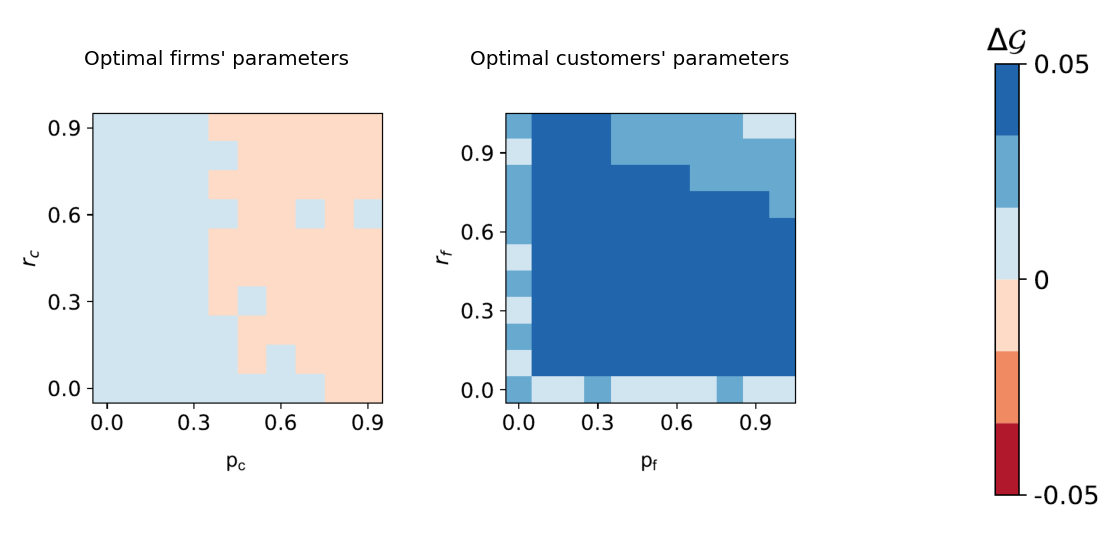

In [46]:
pdf_path1 = "figures/gini-diff-opt-firms.pdf"
pdf_path2 = "figures/gini-diff-opt-customers.pdf"
pdf_path3 = "figures/colorbar-diff-red_blue-gini.pdf"
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3,figsize=(16, 7)) 
ax1.title.set_text("Optimal firms' parameters")
ax2.title.set_text("Optimal customers' parameters")
ax1.axis('off')
image1 = convert_from_path(pdf_path1)[0]
ax1.imshow(image1)
ax2.axis('off')
image2 = convert_from_path(pdf_path2)[0]
ax2.imshow(image2)
ax3.axis('off')
image3 = convert_from_path(pdf_path3)[0]
ax3.imshow(image3)
plt.subplots_adjust(wspace=0, hspace=0)

The difference in Gini coefficient is very small (less than 0.05). 
When $p_c$ is small, unilateral strategy leads to lower inequality, while $p_c$ is large, unilateral strategy leads to higher inequality.
When $p_c$ is high, it means very few new links between firms and customers will be built, and the unilateral strategy has higher probability to successfully build a new link. Because very few links are built, a new link will help the customer gain relative more products (than in the case that many new links are built), increasing the inequality more (comparing to customers fail to build new links).

## Conclusions
From the results above, we conclude that:
1) The environmental consciousness of customers can become a strong motivational factor for firms to reduce their emissions. Hence, firms should be enabled to better know the environmental consciousness of their customers and adapt to it.
2) To reduce supply-demand deficits, our model demonstrates the crucial role of *diversification* in suppliers.
3) The model further highlights the *double impact* of environmental consciousness in reducing emissions: If customers can raise their environmental consciousness, they will choose more products from environmental-friendly firms. Firms have thus a stronger incentive to further improve their environmental consciousness, to attract more demand. This increases the competition with other firms that face a pressure to catch up.
More details about the model are in the paper [Modeling the Impact of Environmental Consciousness on the Supply-Demand Relationship between Firms and Customers](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4403242).